# Load Data

In [3]:
%matplotlib inline
import pandas
import numpy as np
from matplotlib import pyplot as plt

base = 10
threshold = 0.6

df = pandas.read_csv('d.csv', index_col=0)
# df = df.filter(like='ETF', axis=0)
a = df.iloc[:, :-1]
b = df.iloc[:, 1:]
b.columns = a.columns = range(df.shape[1] - 1)
r = (b - a) / a
p = 1 / np.linalg.norm(r, axis=1)
r = (r.T * p).T.values
l = r.shape[0]

correlation = np.ones([l, l])
for i in range(l):
    for j in range(i + 1, l):
        s = (r[i] * r[j]).sum()
        correlation[i][j] = s
        correlation[j][i] = s
correlation[np.abs(correlation) > threshold] = 0
correlation[np.logical_and(np.abs(correlation) <= threshold, correlation != 0)] = 1

d = np.concatenate((np.ones([r.shape[0], 1]) * base,
                        np.add.accumulate(r, axis=1) + np.ones(r.shape) * base), axis=1)

# Test By tiger data

['AveXis', '百思买', 'iShares Floating Rate Note Fund', '美高梅', '新纪元能源', 'ServiceNow', '巴西石油公司', '美国前进保险公司', '埃文斯威市电力', 'Westlake Chemical Corp']
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]
contribution: [1.         1.14008504 1.34833553 1.27941024 1.23366772 1.23495994
 1.29836438 1.23444597 1.21359104 1.30109187]
percentage of total value: [ 0.50824599  1.26997485 84.02492739  1.64703723  3.09163308  1.57446003
  1.11906633  2.54409328  2.51424067  1.70632115]
A,B 0.0016271062295573034 2.2996112434470364
revisit times:  46
11.107533101445913
111.0


Float64Index([ 0.0013476505834728592, -0.0015911131410440982,
               0.0021423660501393993, -0.0027826420963781295,
               0.0015962005992780082,   0.004125487853459564,
                0.004835432933605555,  0.0008835111284355435,
               -0.000627730913360991, -0.0026289581091314407,
              ...
                0.004333442826511602,  -0.001332765757682819,
               0.0059023467791674555,  0.0047660814616075076,
               -0.002905736775341339, -0.0006867701520428815,
              -0.0051587140825749556, -0.0006168763646137165,
               0.0020168710803263323,  0.0018985712567773927],
             dtype='float64', length=111)

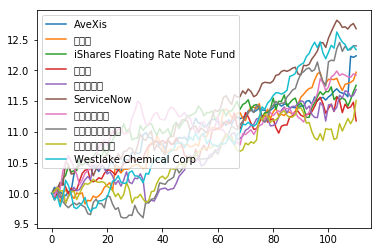

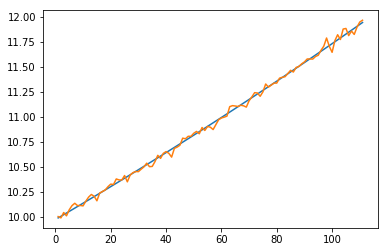

In [6]:
idx = [83, 101, 342, 551, 592, 606, 648, 662, 906, 923]
columns = list(np.array(df.index)[idx])
print(columns)

coridx = np.zeros([len(idx), len(idx)])
for i in range(len(idx)):
    for j in range(i):
        coridx[i][j] = correlation[idx[i]][idx[j]]
        coridx[j][i] = correlation[idx[j]][idx[i]]
print(coridx)

a = d[idx][:, 1:]
b = d[idx][:, :-1]
r = a - b
contri= np.abs(r).mean(axis=1)
contri = contri / contri.min()
print("contribution: {}".format(contri))

graph = pandas.DataFrame(d[idx]).T
graph.columns = columns 
graph.plot()
d[idx].sum(axis=0)[-1]

s = (d[idx]).sum(axis=0)
print("percentage of total value: {}".format(p[idx] / p[idx].sum() * 100))

dates = df.columns.astype(np.float32)
startDate = dates[0]
dates = np.round((dates - startDate) / 3600 / 24 / 1000 / 7) + 1

s = s / len(idx)
A, B = np.polyfit(dates, np.log(s), 1)
print('A,B', A, B)
y = np.exp(A * dates + B)
last = s[0] < y[0]
reg = 0
for i in range(1, len(s)):
    if (s[i] < y[i]) != last:
        reg += 1
        last = s[i] < y[i]
print('revisit times: ', reg)

print(s[64])
print(dates[-1])

plt.figure()
plt.plot(dates, y)
plt.plot(dates, s)
s / y - 1

# Test by yahoo data

In [ ]:
from glob import glob
df = None
for f in glob('sss\\*.csv'):
    name = f.split('\\')[1].split('.')[0]
    if df is None:
        df = pandas.read_csv(f, index_col=0)[['Adj Close']]
        df.columns = [name]
    else:
        csv = pandas.read_csv(f, index_col=0)[['Adj Close']]
        csv.columns = [name]
        df = pandas.concat([df,csv], axis=1)
        
df = df.dropna().T
print(df.shape)
a = df.iloc[:, :-1]
b = df.iloc[:, 1:]
b.columns = a.columns
r = (((b - a) / a).T * p[idx] ).T
r = np.concatenate((np.ones([r.shape[0], 1]) * base,
                    np.add.accumulate(r, axis=1) + np.ones(r.shape) * base), axis=1).T
r = pandas.DataFrame(r)
r.index = df.columns.astype(np.datetime64)
r.columns = df.index
r.plot(figsize=(16, 9))
print(r.shape)

y2 = r.sum(axis=1)
#plt.figure(figsize=(16, 9))
plt.plot(df.columns.astype(np.datetime64), y2 / len(idx))


# Test random output distribution

In [ ]:
import random

dist = []
n = 6
for i in range(100000):
    choice = random.sample(range(d.shape[0]), n)
    bad = True
    while bad:
        bad = False
        for k in range(len(choice)):
            for l in range(k):
                if np.abs(cor[choice[k]][choice[l]]) > 0.75:
                    bad = True
                    break
            if bad:
                break
        if bad:
            choice = random.sample(range(d.shape[0]), n)

    s = d[choice].sum(axis=0)
    s = s / n
    m = s.mean()
    s = s / m
    x = np.arange(len(s)) + 1
    a, b = np.polyfit(x, np.log(s), 1)
    y = np.exp(a * x + b)

    # reg times
    last = s[0] < y[0]
    reg = 0
    regDist = [0]
    for i in range(1, len(s)):
        if (s[i] < y[i]) != last:
            regDist.append(i)
            reg += 1
            last = s[i] < y[i]

    # reg distribution
    regDist = np.array(regDist)
    regStd = (regDist[1:] - regDist[:-1]).std()
    dist.append(regStd)
    
pandas.DataFrame(dist).hist(bins=1000)
pandas.qcut(dist,  [0, 0.05, 0.1, 0.25, 0.5, 0.75, 1])

# Load Weekly data and clean into d.csv

In [ ]:
%matplotlib inline
import pandas
from glob import glob
import numpy as np

df = None
for f in glob('D:\\work\\main\\IB\\*_week.csv'):
    if df is None:
        df = pandas.read_csv(f, index_col=0).T
    else:
        df = pandas.concat([df,pandas.read_csv(f, index_col=0).T], axis=1)

d = df.iloc[-112:-1,:]
d = d.dropna(axis=1,how='any').astype('float32').T
d.to_csv('d.csv')

# Load Daily data

In [ ]:
from glob import glob
%matplotlib inline
import pandas
import numpy as np
from matplotlib import pyplot as plt

daily = None
for f in glob('D:\\work\\main\\IB\\*_day.csv'):
    if daily is None:
        daily = pandas.read_csv(f, index_col=0).T
    else:
        daily = pandas.concat([daily,pandas.read_csv(f, index_col=0).T], axis=1)
daily.to_csv('day.csv')

# Test by day data

In [ ]:
from glob import glob
daily = pandas.read_csv('day.csv', index_col=0)[columns].T
print(columns)
moneyNeeded = 100 / (p[idx]/p[idx].sum()/daily.T.iloc[-1,:].values)[2]
tobuy = np.round(moneyNeeded * p[idx]/p[idx].sum() /  daily.T.iloc[-1,:].values)
moneyNeeded = tobuy * daily.T.iloc[-1,:].values
print('shares ', str(tobuy), tobuy.sum(), moneyNeeded)
moneyNeeded = moneyNeeded.sum()
print(moneyNeeded)

a = daily.iloc[:, :-1]
b = daily.iloc[:, 1:]
a.columns = b.columns
r = ((b / a - 1).T * p[idx] ).T
print(r.shape)

dates = daily.columns.astype(np.float32)
dates = np.round((dates - startDate) / 3600 / 24 / 1000) / 7 + 1
base = 10.4
r = np.concatenate((np.ones([r.shape[0], 1]) * base,
                    np.add.accumulate(r, axis=1) + np.ones(r.shape) * base), axis=1).T
r = pandas.DataFrame(r)
r.columns = columns
r.index = dates
r.plot(figsize=(16,9))

y = np.exp(A * dates + B) * moneyNeeded / 10
y2 = r.sum(axis=1) / len(columns) * moneyNeeded / 10
plt.figure(figsize=(16,9))
plt.plot(dates, y)
plt.plot(dates, y2)
#plt.plot(111, np.exp(A * 111 + B), marker='o', color='r', ls='')
#y2[-1] / y[-1] - 1